# BPSD: Evaluate Synchronization Accuracy

- Measure Positions from two different sources:
- Manual measure annotations from Kempff recordings (WK64) transferred via audio-audio synchronization
- Measure positions from score transferred via score-audio sync

Johannes Zeitler (johannes.zeitler@audiolabs-erlangen.de), 2024

In [1]:
import os
import pandas as pd
import numpy as np
from itertools import groupby
import scipy

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
pieces = [f.split(".")[0] for f in os.listdir(os.path.join("../", "1_Audio")) if ".wav" in f]

pieces.sort()

In [3]:
dir_measures_sync = os.path.join("../", "2_Annotations", "ann_audio_measure")
dir_ann_audio_note = os.path.join("../", "4_misc", "ann_audio_note_noAnchor")

In [31]:
pieces_error_transc_finetuned = {}

for piece in tqdm(pieces):
    all_absError = []
    measures = pd.read_csv(os.path.join(dir_measures_sync, "%s.csv"%(piece)), sep=";")
    
    noteIn = pd.read_csv(os.path.join(dir_ann_audio_note, "%s.csv"%(piece)), sep=";")
    
    
    start_pairs = [[start_m, start_s] for start_m, start_s in zip(noteIn.start_meas, noteIn.start)]
    start_pairs_unique = np.array([pair for pair,_ in groupby(start_pairs)])
    start_pairs_unique.sort(axis=0)        

    meas_to_time_annot = scipy.interpolate.interp1d(start_pairs_unique[:,0], start_pairs_unique[:,1], 
                                              kind='linear', bounds_error=False, fill_value='extrapolate')
    
    
    
    measures["timeFromNote"] = meas_to_time_annot(measures.measure)
    
    
    measures["error"] = measures.time - measures.timeFromNote
    measures["squaredError"] = measures.error**2
    measures["absError"] = np.abs(measures.error)
    
    isNote = []
    
    for _, row in measures.iterrows():
        if min(np.abs(noteIn.start_meas-row.measure)) < 1e-2: isNote.append(True)
        else: isNote.append(False)
        
    measures["isNote"] = isNote
    
    MSE = np.mean(measures.squaredError[:-1])
    RMSE = np.sqrt(MSE)
    
    MAE = np.mean(measures.absError[:-1])
    
    MSE_isNote = np.mean(measures.squaredError[:-1][np.where(measures.isNote[:-1])[0]])
    RMSE_isNote = np.sqrt(MSE_isNote)
    
    MAE_isNote = np.mean(measures.absError[:-1][np.where(measures.isNote[:-1])[0]])
    
    grossError = np.mean(measures.absError[:-1] > 0.07)
    
    grossError_isNote = np.mean(measures.absError[:-1][np.where(measures.isNote[:-1])[0]] > 0.07)
    
    
    for err in measures.absError:
        all_absError.append(err)

    #break

   
    pieces_error_transc_finetuned[piece] = {"MSE": MSE,
                           "MSE_isNote": MSE_isNote,
                           "RMSE": RMSE, 
                           "RMSE_isNote": RMSE_isNote,
                           "MAE": MAE,
                           "MAE_isNote": MAE_isNote,
                           "grossError": grossError,
                           "grossError_isNote": grossError_isNote,
                           "absErr": [err for err in measures.absError],
                           "absErr_isNote": [err for err in measures.absError[np.where(measures.isNote)[0]]]}

  0%|          | 0/352 [00:00<?, ?it/s]

In [32]:
performers = list(set([p.split("_")[-1] for p in pieces]))
performers.sort()

In [33]:
sonatas = list(set([p.split("_")[1] for p in pieces]))
sonatas.sort()

In [42]:
MAE_all = np.zeros((len(sonatas), len(performers)))

In [45]:
for iSon, sonata in enumerate(sonatas):
    for iPerf, performer in enumerate(performers):

        MAE_all[iSon, iPerf] = pieces_error_transc_finetuned["Beethoven_%s_%s"%(sonata, performer)]["grossError_isNote"]

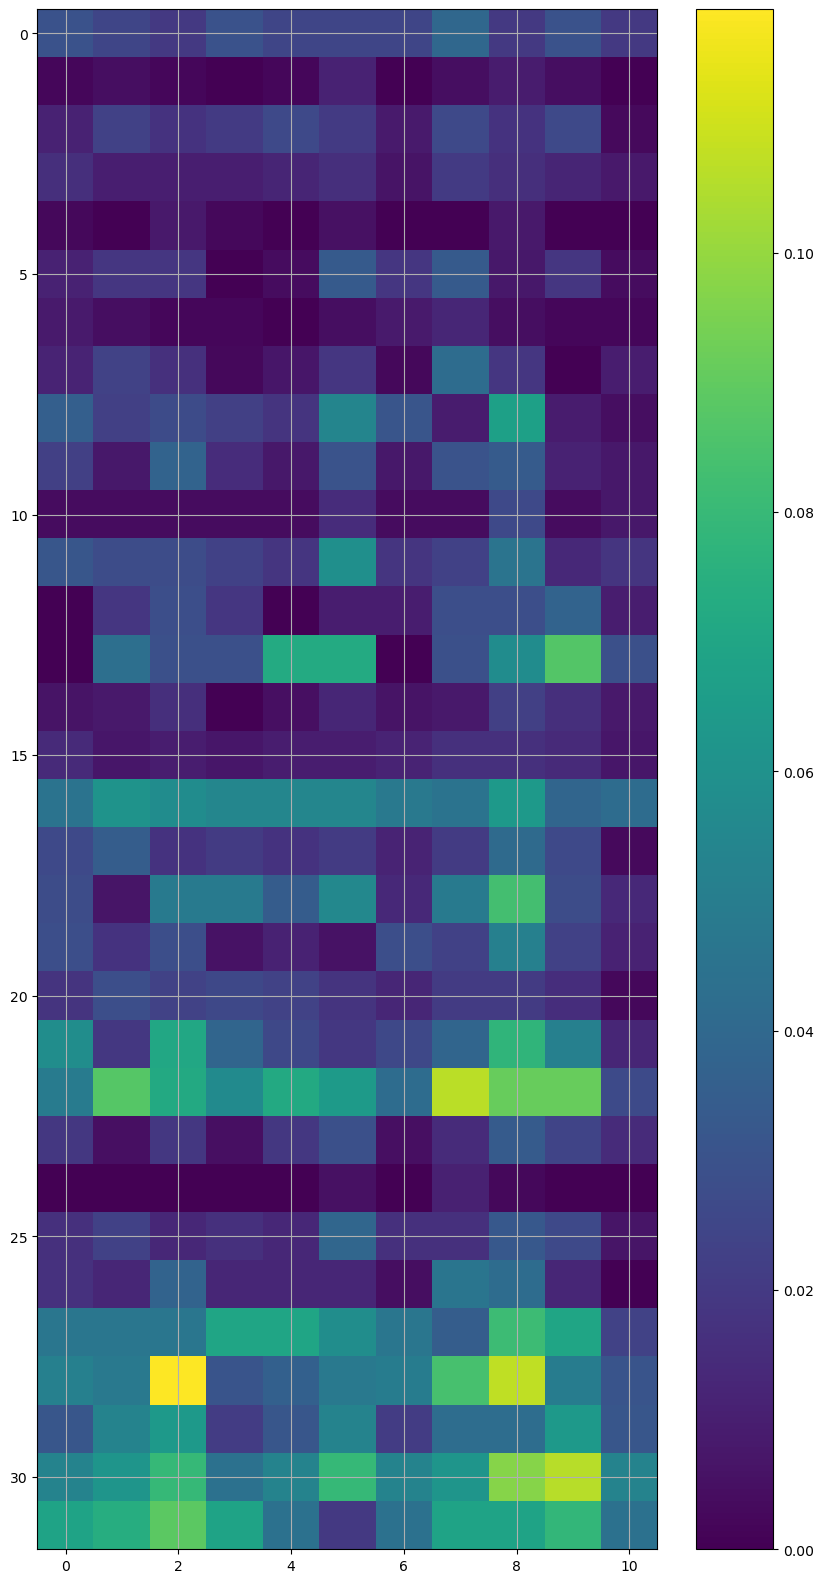

In [46]:
plt.figure(figsize=(10,20))
plt.imshow(MAE_all, aspect="auto", interpolation="None")
plt.yticklabels = sonatas
plt.grid()
plt.colorbar()
plt.show()

In [37]:
absErr_performers = []
absErr_isNote_performers = []
for performer in performers:
    absErr_performers.append([])
    absErr_isNote_performers.append([])
    
for piece in pieces:
    absErr = pieces_error_transc_finetuned[piece]["absErr"]
    absErr_isNote = pieces_error_transc_finetuned[piece]["absErr_isNote"]

    for i, perf in enumerate(performers):
        if perf in piece:
            absErr_performers[i] += absErr
            absErr_isNote_performers[i] += absErr_isNote
            
for i in range(len(absErr_performers)):
    absErr_performers[i] = np.array(absErr_performers[i])
    absErr_isNote_performers[i] = np.array(absErr_isNote_performers[i])

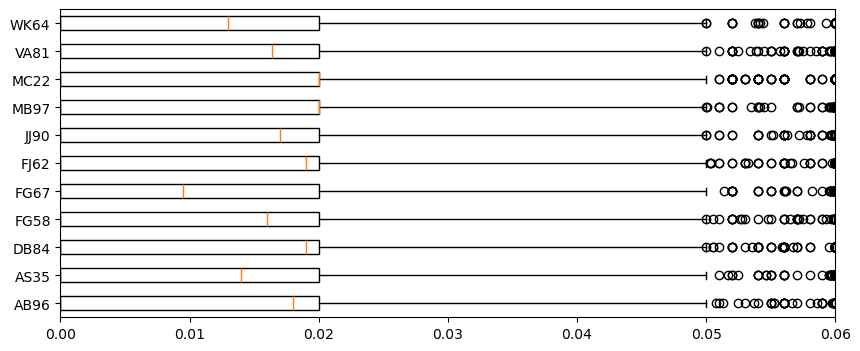

In [38]:
plt.figure(figsize=(10,4))
plt.boxplot(absErr_performers, vert=False)
plt.xlim([0., .06])
plt.yticks(np.arange(len(performers))+1, performers)
plt.show()

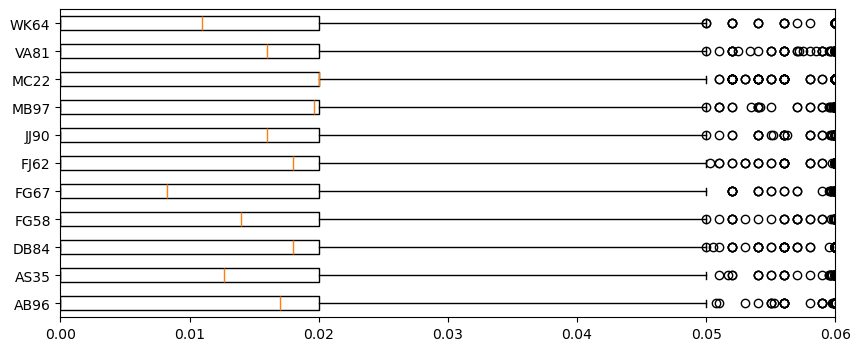

In [39]:
plt.figure(figsize=(10,4))
plt.boxplot(absErr_isNote_performers, vert=False)
plt.xlim([0., .06])
plt.yticks(np.arange(len(performers))+1, performers)
plt.show()

In [12]:
print("Version & mean & median & 95 & mean_isNote & median_isNote & 95_isNote \\\\")
for i, performer in enumerate(performers):
    print("%s & %5.2f & %5.2f & %5.2f & %5.2f & %5.2f & %5.2f \\\\"%(performer, np.mean(absErr_performers[i])*1e3, np.median(absErr_performers[i])*1e3, np.sort(absErr_performers[i])[int(.95*len(absErr_performers[i]))]*1e3,
                                                          np.mean(absErr_isNote_performers[i])*1e3, np.median(absErr_isNote_performers[i])*1e3, np.sort(absErr_isNote_performers[i])[int(.95*len(absErr_isNote_performers[i]))]*1e3))
    
all_absErr = np.concatenate(absErr_performers)
all_absErr_isNote = np.concatenate(absErr_isNote_performers)

print("%s & %5.2f & %5.2f & %5.2f & %5.2f & %5.2f & %5.2f \\\\"%("all", np.mean(all_absErr)*1e3, np.median(all_absErr)*1e3, np.sort(all_absErr)[int(.95*len(all_absErr))]*1e3,
                                                          np.mean(all_absErr_isNote)*1e3, np.median(all_absErr_isNote)*1e3, np.sort(all_absErr_isNote)[int(.95*len(all_absErr_isNote))]*1e3))
    

Version & mean & median & 95 & mean_isNote & median_isNote & 95_isNote \\
AB96 & 27.82 & 18.00 & 46.00 & 18.34 & 17.00 & 40.00 \\
AS35 & 24.78 & 15.00 & 54.00 & 18.17 & 13.00 & 40.33 \\
DB84 & 29.08 & 19.00 & 60.00 & 19.35 & 18.00 & 54.00 \\
FG58 & 22.74 & 16.00 & 41.00 & 16.72 & 14.00 & 40.00 \\
FG67 & 25.07 &  9.50 & 40.00 & 17.44 &  8.29 & 40.00 \\
FJ62 & 25.24 & 19.00 & 60.00 & 18.54 & 18.00 & 45.00 \\
JJ90 & 23.70 & 17.00 & 43.00 & 16.01 & 16.00 & 40.00 \\
MB97 & 30.03 & 20.00 & 60.00 & 20.14 & 19.67 & 47.00 \\
MC22 & 27.12 & 20.00 & 63.50 & 21.16 & 20.00 & 60.00 \\
VA81 & 23.99 & 16.71 & 56.00 & 17.08 & 16.00 & 41.00 \\
WK64 & 20.21 & 13.00 & 40.00 & 14.47 & 11.00 & 40.00 \\
all & 25.44 & 17.00 & 53.00 & 17.95 & 16.00 & 40.00 \\
